In [1]:
%pwd

'/content'

In [2]:
%cd '/content/drive/MyDrive/한국직업전문학교(2024.06)/실습'

/content/drive/MyDrive/한국직업전문학교(2024.06)/실습


### 필요 모듈 생성

In [8]:
# utils.py 파일 생성
with open('utils.py', 'w') as f:
    f.write('''
import collections
import datetime
import time
import torch
import torch.distributed as dist
import torchvision.transforms as T
import torchvision.transforms.functional as F

class SmoothedValue(object):
    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = collections.deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.total += value * n
        self.count += n

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque))
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value,
        )

class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = collections.defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError(f"'MetricLogger' object has no attribute '{attr}'")

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(f"{name}: {str(meter)}")
        return self.delimiter.join(loss_str)

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ""
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt="{avg:.4f}")
        data_time = SmoothedValue(fmt="{avg:.4f}")
        space_fmt = ":" + str(len(str(len(iterable)))) + "d"
        log_msg = [
            header,
            "[{0" + space_fmt + "}/{1}]",
            "eta: {eta}",
            "{meters}",
            "time: {time}",
            "data: {data}",
        ]
        if torch.cuda.is_available():
            log_msg.append("max mem: {memory:.0f}")
        log_msg = self.delimiter.join(log_msg)
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(
                        log_msg.format(
                            i,
                            len(iterable),
                            eta=eta_string,
                            meters=str(self),
                            time=str(iter_time),
                            data=str(data_time),
                            memory=torch.cuda.max_memory_allocated() / MB,
                        )
                    )
                else:
                    print(
                        log_msg.format(
                            i,
                            len(iterable),
                            eta=eta_string,
                            meters=str(self),
                            time=str(iter_time),
                            data=str(data_time),
                        )
                    )
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print(f"{header} Total time: {total_time_str} ({total_time / len(iterable):.4f} s / it)")

def collate_fn(batch):
    return tuple(zip(*batch))

def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def reduce_dict(input_dict, average=True):
    """
    Reduce the values in the dictionary from all processes so that all processes have
    the averaged results. Returns a dict with the same fields as input_dict, after reduction.
    """
    if get_world_size() < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.reduce(values, dst=0)
        if dist.get_rank() == 0 and average:
            values /= get_world_size()
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

import random
import torchvision.transforms as T
import torchvision.transforms.functional as F
from PIL import Image

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class RandomHorizontalFlip:
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        if random.random() < self.flip_prob:
            image = F.hflip(image)
            if "boxes" in target:
                _, width = image.shape[1:]
                bbox = target["boxes"]
                bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
                target["boxes"] = bbox
        return image, target

def get_transform(train):
    transforms = [ToTensor()]
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)
''')


In [22]:
# engine.py 파일 생성
with open('engine.py', 'w') as f:
    f.write('''
import math
import sys
import time
import torch
import utils

import math
import sys
import time
import torch

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = f'Epoch: [{epoch}]'

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses, **loss_dict)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        model_time = time.time()
        outputs = model(images)
        model_time = time.time() - model_time

        outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]

        for target, output in zip(targets, outputs):
            utils.reduce_dict(target)
            utils.reduce_dict(output)

    return metric_logger

''')

In [23]:
import importlib

import utils
import engine

importlib.reload(utils)
importlib.reload(engine)

from engine import train_one_epoch, evaluate
from utils import collate_fn

### 데이터셋 정의

In [25]:
import torch
import torchvision
import os
import numpy as np
from PIL import Image
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import utils
import engine
import importlib

importlib.reload(utils)
importlib.reload(engine)

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)


# 장치 설정
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 데이터셋 및 데이터 로더 설정
dataset = PennFudanDataset('PennFudanPed', utils.get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', utils.get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))
)


### 모델 준비 및 수정

In [38]:
# 모델 정의
from torchvision.models.detection.faster_rcnn import FasterRCNN, FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# def get_model_instance_segmentation(num_classes):
#     backbone = resnet_fpn_backbone('resnet101', weights="ResNet101_Weights.DEFAULT") # ResNet101 모델의 가중치 불러오기
#     model = FasterRCNN(backbone, num_classes=num_classes)
#     return model

def get_model_instance_segmentation(num_classese):
    weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


In [39]:
# 모델 초기화
num_classes = 2
model = get_model_instance_segmentation(num_classes)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [40]:
# Optimizer, learning_rate
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [41]:
# 모델 훈련
num_epochs= 10

for epoch in range(num_epochs):
    engine.train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    engine.evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:00:59  lr: 0.000090  loss: 0.7490 (0.7490)  loss_classifier: 0.4967 (0.4967)  loss_box_reg: 0.2341 (0.2341)  loss_objectness: 0.0144 (0.0144)  loss_rpn_box_reg: 0.0038 (0.0038)  time: 0.9937  data: 0.2975  max mem: 4955
Epoch: [0]  [10/60]  eta: 0:00:26  lr: 0.000936  loss: 0.6702 (0.6647)  loss_classifier: 0.3392 (0.3560)  loss_box_reg: 0.2676 (0.2885)  loss_objectness: 0.0172 (0.0166)  loss_rpn_box_reg: 0.0027 (0.0034)  time: 0.5375  data: 0.0348  max mem: 4955
Epoch: [0]  [20/60]  eta: 0:00:21  lr: 0.001783  loss: 0.5203 (0.5432)  loss_classifier: 0.2219 (0.2611)  loss_box_reg: 0.2471 (0.2641)  loss_objectness: 0.0117 (0.0137)  loss_rpn_box_reg: 0.0024 (0.0043)  time: 0.5255  data: 0.0176  max mem: 4955
Epoch: [0]  [30/60]  eta: 0:00:15  lr: 0.002629  loss: 0.3533 (0.4873)  loss_classifier: 0.0997 (0.2034)  loss_box_reg: 0.2471 (0.2673)  loss_objectness: 0.0077 (0.0120)  loss_rpn_box_reg: 0.0035 (0.0046)  time: 0.5282  data: 0.0179  max mem: 4955
Epoch: [

In [42]:
# 모델 평가
model.eval()
with torch.no_grad():
    for images, targets in data_loader_test:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        predictions = model(images)

        print(predictions[0])
        break

{'boxes': tensor([[210.7678,  99.4016, 347.4876, 386.2384],
        [  0.0000, 106.8899,  88.4936, 382.9193],
        [ 34.6629,  99.1250,  95.5125, 343.0302]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.9958, 0.7326], device='cuda:0')}


### 시각화

In [43]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(image, targets, predictions, score_threshold=0.0):
    plt.figure(figsize=(16, 8))
    plt.imshow(image)
    ax = plt.gca()

    # 실제 타겟 박스 그리기
    for box in targets.get('boxes', []):
        if isinstance(box, torch.Tensor):
            box = box.tolist()  # 리스트로 변환
        if isinstance(box, float):  # 박스가 float인 경우 (잘못된 형식)
            continue
        print(f"Target box: {box}")  # 디버깅 메시지
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='green', facecolor='none', label='Target')
        ax.add_patch(rect)

    # 예측 박스 그리기
    if predictions['scores'].dim() == 0:
        # 예측이 하나만 있을 때
        score = predictions['scores'].item()
        if score >= score_threshold:
            box = predictions['boxes'].tolist()
            print(f"Prediction box: {box} with score: {score}")  # 디버깅 메시지 추가
            x_min, y_min, x_max, y_max = box
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=2, edgecolor='red', facecolor='none', label='Prediction')
            ax.add_patch(rect)
            # 신뢰도 점수 추가
            ax.text(x_min, y_min, f'{score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))
    else:
        # 예측이 여러 개 있을 때
        for i, box in enumerate(predictions['boxes']):
            score = predictions['scores'][i].item()
            if score < score_threshold:
                continue
            if isinstance(box, torch.Tensor):
                box = box.tolist()  # 리스트로 변환
            if isinstance(box, float):  # 박스가 float인 경우 (잘못된 형식)
                continue
            print(f"Prediction box: {box} with score: {score}")  # 디버깅 메시지
            x_min, y_min, x_max, y_max = box
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=2, edgecolor='red', facecolor='none', label='Prediction')
            ax.add_patch(rect)
            # 신뢰도 점수 추가
            ax.text(x_min, y_min, f'{score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))

    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys())

    plt.axis('off')
    plt.show()

Saving walker.jpg to walker.jpg
Prediction box: [839.8782348632812, 154.89646911621094, 865.2237548828125, 207.72332763671875] with score: 0.9976233839988708


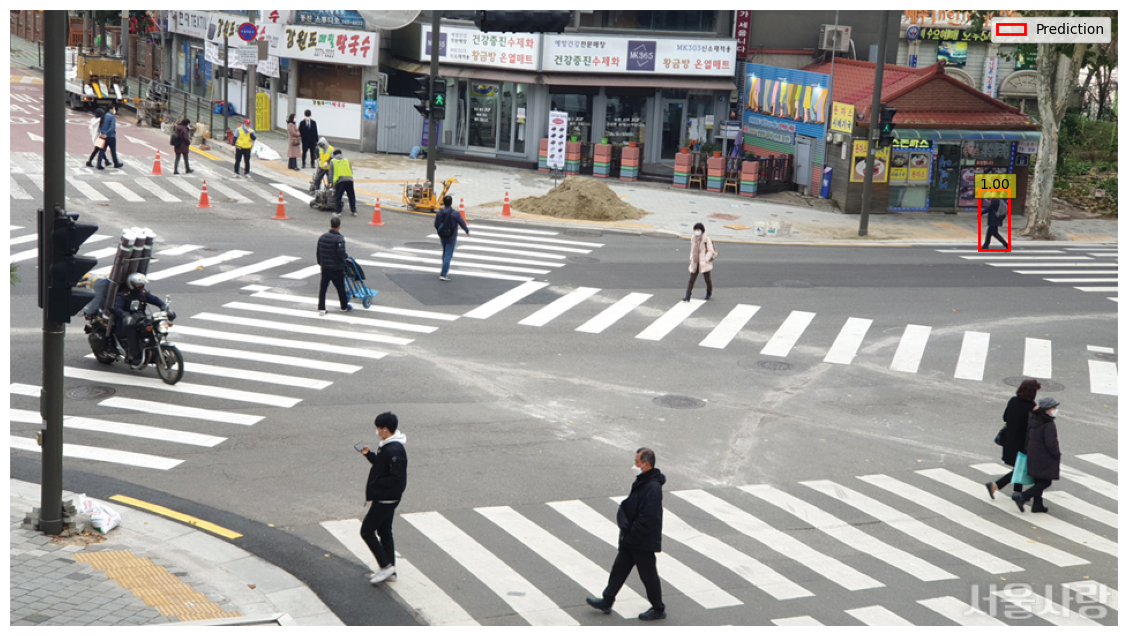

In [45]:
import torchvision.transforms as T
from PIL import Image

from google.colab import files # colab에 file upload
uploaded = files.upload()

img_path = list(uploaded.keys())[0]
img = Image.open(img_path).convert("RGB")
img = T.ToTensor()(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    predictions = model(img)

img_T = img[0].cpu().numpy().transpose(1, 2, 0) # 형 변환
prediction = {k: v[0].cpu() for k, v in predictions[0].items()}

visualize_predictions(img_T,  {'boxes':[], 'labels':[]}, prediction, score_threshold=0)

### 모델 가중치 저장

In [46]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50.pth')